In [216]:
%matplotlib inline


In [237]:
# %load runBicycleTest.py
import numpy as np
import matplotlib.pyplot as plt
import rhs
import LinearController
import graph
from unpackState import *
from tableBased import *
import integrator
import scipy.integrate as inter
import time
%autoreload LinearController


# use Euler Integration to simulate a bicycle
def runBicycleTest(stateflag, controller, name, reward_flag, simulation_duration,
  isGraphing  = True, figObject = None, tstep_multiplier = 1,
  integrator_method = "fixed_step_RK4",
  USE_LINEAR_EOM = False, timestep = 1/50, starting_state3 = None, isPrinting= True,
  v = 3.0, clip_delta = True, delta_limit = None, max_steer_rate = None):


  if stateflag == None:
    state8 = np.array(state3_to_state8(starting_state3, v =v))
  else:
    state8 = getStartingState8(stateflag, v)

  #controllers get a reward every timestep, so normalize the rewards by a canonical
  # timestep so that we can compare rewards between controllers with different
  # timesteps
  canonical_timestep = 1/50

  if not controller.is_initialized:
    print("# # # " + name + " is not intialized # # # \n skipping " + name)
    return figObject

  t_test1 = time.time()



  numTimeSteps = int(simulation_duration/timestep)+1

  #create arrays before loop
  success = True
  numStates = state8.size
  states = np.zeros([numTimeSteps, numStates])
  motorCommands = np.zeros([numTimeSteps, 1])

  #initialize starting values of arrays
  # states8[1,:] = state8
  # motorCommands[1] = 0

  count = 0
  cum_reward = 0
  sim_time = 0

  is_fallen = False

  while( (count < numTimeSteps) and not (is_fallen)):

    #calculate control action
    u = controller.act(state8, timestep, max_steer_rate = max_steer_rate)


    #clip u to avoid singularity when delta = pi/4
    if clip_delta:
      #print("time: ", sim_time)

      delta= state8[5]
      #print("delta: ",delta, "u: ",u)
      if delta_limit == None:
        delta_threshold = 1.4 #1.4 rad = 80 degrees pi/2 = 1.5708
      else:
        delta_threshold = delta_limit
      if delta < -delta_threshold:

        u = np.max([u,0])
        #print("clipped u: ",u)
      elif delta > delta_threshold:
        u = np.min([u,0])
        #print("clipped u: ",u)

      delta_threshold_danger = 1.5  #pi/2 = 1.5708
      if np.abs(delta)>delta_threshold_danger:
        #print("delta: ", delta)
        #print("delta exceeds threshold to avoid singularity")
        assert(np.abs(delta)<delta_threshold_danger)


    new_state8, reward, is_fallen = step(state8, u, reward_flag, tstep_multiplier = 1,
      method = "fixed_step_RK4", USE_LINEAR_EOM = USE_LINEAR_EOM, timestep = timestep)

    states[count,:] = state8
    motorCommands[count] = u

    if not is_fallen:
      sim_time += timestep
    cum_reward += reward
    count += 1



    state8 = new_state8

  states = states[:count,:]
  motorCommands = motorCommands[:count]

  cum_reward = cum_reward / (canonical_timestep/timestep)
  success = not is_fallen

  #### copied from simulate_episode. used to calculate which states are inside
  # the last gridpoint of a VI model
  # points_inside_last_gridpoint = []
  # if plot_is_inside_last_gridpoint:
  #   points_inside_last_gridpoint = \
  #     self.calculate_points_inside_last_gridpoint(states8)

  t_test2 = time.time()

  if isPrinting:
    print(name + " success: " + str(success) + ", cumulative reward:" + str(cum_reward) + ",  time in simulation: "
          + str(sim_time) + "\n" +
          "Tested " + name + " in " + str(t_test2-t_test1) + " sec of computer time")

  if isGraphing:
    figObject = graph.graph(states, motorCommands, figObject, [], name)


  return success, figObject

In [238]:


import LinearController
from StateGridPoints import *
#from runBicycleTest import *
import time
from valueIteration import *
from LinearController import getLQRGains
from datetime import datetime
from matplotlib import colors
%autoreload LinearController


In [236]:
def calc_basin_of_attraction(controller, name, state_table_flag, v,
                             save = True, delta_limit = None, max_steer_rate = None):
    #state_table_flag is for the state table we will use to make the
    # grid points (ie, the controller may have been trained on a 
    #different one, but it will be plotted on state_table_flag)
    
    GridPoints = StateGridPoints()
    GridPoints.set_state_grid_points(state_table_flag)

  #with delta = 0

    phi_points, phi_dot_points,  delta_points = \
        np.meshgrid(GridPoints.phi_grid, GridPoints.phi_dot_grid,
                    [0.0])
    #if change delta from 0, think carefully about how
    #to mirror the points when plotting it
    
    phi_and_phi_dot_points= np.rec.fromarrays([phi_points, 
                                               phi_dot_points,
        delta_points], 
        names='phi_points,phi_dot_points, delta_points')
    
    print("calculating basis of attraction for controller " +
          name)
    success_array = np.zeros((GridPoints.len_phi_half_grid,
      GridPoints.len_phi_dot_grid))
     
    for (i, phi) in enumerate(GridPoints.phi_half_grid):

        print("phi: " + str(phi))
        for (j, phi_dot) in enumerate(GridPoints.phi_dot_grid):

            (success, _ ) = runBicycleTest(stateflag = None, 
                                           controller = controller,
            name = "", reward_flag = 14, simulation_duration= 2.0,
            isGraphing  = False, figObject = None, isPrinting = False,
            integrator_method = "fixed_step_RK4",
            USE_LINEAR_EOM = False, timestep = 1/50,
            starting_state3 = [phi, phi_dot, 0.0],
            v = v, delta_limit = delta_limit, max_steer_rate = max_steer_rate)

            success_array[i,j] = success
    
    if save:
        np.savetxt("BasinOfAttraction/"+ name 
                   + "_BasisOfAttraction.csv", success_array,
           delimiter = ",")

    
    return success_array

In [4]:
def load_basin(name):
    success_array = np.loadtxt("BasinOfAttraction/"+ name 
                   + "_BasisOfAttraction.csv",
           delimiter = ",")
    return success_array

In [87]:
def calc_d_size(controller, v):
    
    #everything is in terms of phi and phi_dot, not pixels
    n = 50
    phi_dot_ortho_list = np.linspace(0,0.178,n)  #start at 0 because we only want to search over half of the state space
    phi_ortho_list = phi_dot_ortho_list*(.975/.223)
    
    success_array = np.zeros(n)
    
    for i in range(n):
        phi_dot = phi_dot_ortho_list[i]
        phi = phi_ortho_list[i]
        
        (success, _ ) = runBicycleTest(stateflag = None, 
            controller = controller,
            name = "", reward_flag = 14, simulation_duration= 2.0,
            isGraphing  = False, figObject = None, isPrinting = False,
            integrator_method = "fixed_step_RK4",
            USE_LINEAR_EOM = False, timestep = 1/50,
            starting_state3 = [phi, phi_dot, 0.0],
            v = v)

        success_array[i] = success
    
    #make sure there is a boundry between falling and not falling that we can reach
    assert(success_array[0] != success_array[-1])
    
    i_s = np.nonzero(0==success_array)
   
    i = i_s[0][0]    #why do I need to index twice, idk man. np.nonzero is wierd
    d_phi = phi_ortho_list[i]
    d_phi_dot = phi_dot_ortho_list[i]
    
    return (d_phi_dot,d_phi)
    
#     xpoints_ortho = xpoints_ortho + GridPoints.len_phi_dot_grid//2
#     ypoin

In [89]:
linear_0_5_controller = LinearController.LinearController(getLQRGains("lqrd_0.5m_s"))
linear_0_25_controller =  LinearController.LinearController(getLQRGains("lqrd_0.25m_s"))
linear_1_controller =  LinearController.LinearController(getLQRGains("lqrd_1m_s"))
linear_2_controller =  LinearController.LinearController(getLQRGains("lqrd_2m_s"))
linear_3_controller =  LinearController.LinearController(getLQRGains("lqrd_3m_s"))

d_0_25 = calc_d_size(linear_0_25_controller, v = 0.25)
d_0_5 = calc_d_size(linear_0_5_controller, v = 0.5)
d_1 = calc_d_size(linear_1_controller, v = 1)
d_2 = calc_d_size(linear_2_controller, v = 2)
d_3 = calc_d_size(linear_3_controller, v = 3)

In [175]:
d_0_25_lin = d_0_25
d_0_5_lin = d_0_5
d_1_lin = d_1
d_2_lin = d_2
d_3_lin = d_3

In [178]:
d_0_25_lin

(0.025428571428571425, 0.11117873158231902)

In [174]:
def calc_d_VI(v, controller_name,):

    #name = "VI_r14_s6_a1"
    #name = "VI_r14_a1_s16_v1_50episodes"
    # name = "VI_r14_a1_s16_v0.5_100episodes"
    #name = "VI_r14_a1_s16_v2_30episodes"
    VI_model = ValueIteration(state_grid_flag = 16, action_grid_flag = 1,
    reward_flag = 14, Ufile = "modelsB/"+controller_name, use_only_continuous_actions = False,
    remake_table = False, step_table_integration_method = "fixed_step_RK4",
    USE_LINEAR_EOM = False, name = controller_name, timestep = 1/50, v = v)


    VI_model.init_controller(use_continuous_actions = True,
      use_continuous_state_with_discrete_actions = True,
      controller_integration_method = "fixed_step_RK4",
      use_regression_model_of_table = False)

    return calc_d_size(VI_model, v = v)

In [176]:
d_0_25_VI = calc_d_VI(0.25, "VI_r14_a1_s16_v0.25_100episodes")
d_0_5_VI = calc_d_VI(0.5, "VI_r14_a1_s16_v0.5_100episodes")
d_1_VI = calc_d_VI(1, "VI_r14_a1_s16_v1_50episodes")

Initializing VI model
Using State Grid Flag 16
Loading step_table modelsB/VI_r14_a1_s16_v0.25_100episodes.csv from file
Initialized VI Model modelsB/VI_r14_a1_s16_v0.25_100episodes.csv in 249.7050347328186sec
Initializing VI model
Using State Grid Flag 16
Loading step_table modelsB/VI_r14_a1_s16_v0.5_100episodes.csv from file
Initialized VI Model modelsB/VI_r14_a1_s16_v0.5_100episodes.csv in 228.20974564552307sec
Initializing VI model
Using State Grid Flag 16
Loading step_table modelsB/VI_r14_a1_s16_v1_50episodes.csv from file
Initialized VI Model modelsB/VI_r14_a1_s16_v1_50episodes.csv in 188.61692667007446sec


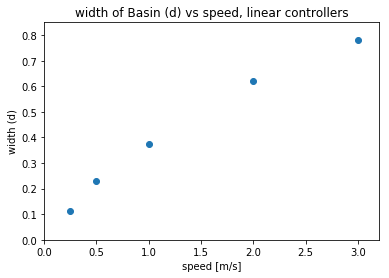

In [109]:
#plot different d values vs speed
d_vals_list = [d_0_25, d_0_5, d_1, d_2, d_3]
speeds = [0.25, 0.5, 1, 2, 3]
d_mags = np.zeros(len(d_vals_list))
d_phis = np.zeros(len(d_vals_list))

for (i, d_vals) in enumerate(d_vals_list):
    d_mags[i] = np.sqrt(d_vals[0]**2 + d_vals[1]**2)
    #d_phis[i] = d_vals[1]
    
fig, ax = plt.subplots(1,1)

ax.plot(speeds, d_mags, "o")
ax.set_title("width of Basin (d) vs speed, linear controllers")
ax.set_ylabel("width (d)")
ax.set_xlabel("speed [m/s]")
ax.set_ylim([0,0.85])
ax.set_xlim([0,3.2])
#ax.plot(speeds, d_phis)

plt.show()

In [172]:
def plot_basin_from_arrays(success_arrays, names, state_table_flag, d_vals_list = None):
    #success_arrays is a list of arrays of successes each generated
    #with a call to 'calc_basin_of_attraction'
    n = len(success_arrays)
    
    fig=plt.figure(figsize=(18, 10*n), dpi= 80, facecolor='w', edgecolor='k')
    axs = fig.subplots(n,1)
    
    GridPoints = StateGridPoints()
    GridPoints.set_state_grid_points(state_table_flag)
    
    #scale multiplier is the difference between the phi and phi_dot scales
    if state_table_flag == 16.2:
        scale_multiplier = 2
        phi_scale = 50
        phi_dot_scale = 25
    elif state_table_flag == 16.3:
        scale_multiplier = 1
        phi_scale = 25
        phi_dot_scale = 25
    
    difference_array = np.zeros((GridPoints.len_phi_grid, GridPoints.len_phi_dot_grid))
    
    ##### get line of constant energy? to plot (eigvector of A)
    xpoints = np.linspace(-GridPoints.len_phi_dot_grid//2, 
                          GridPoints.len_phi_dot_grid//2,11)
    
    ypoints = xpoints*(-0.223/0.975)*(scale_multiplier) #scale by 2 since phi_dot grid has 2x the spacing of phi grid
    #magic numbers from eigenvector of A w/ negative eigenvalue
#     ypoints = np.interp(ypoints_unscaled, 
#            (ypoints_unscaled.min(), ypoints_unscaled.max()),
#            (GridPoints.len_phi_half_grid*-1, 
#             GridPoints.len_phi_half_grid))
    
    #more origin to center
    xpoints = xpoints + GridPoints.len_phi_dot_grid//2
    ypoints = ypoints + GridPoints.len_phi_grid//2
    

    #test plotting orthogonal line
#     xpoints_ortho = np.linspace(-0.178, 0.178,31)*20 #since scale is 0.4
#     ypoints_ortho = xpoints_ortho*(.975/.223)*scale_multiplier
    
#     xpoints_ortho = xpoints_ortho + GridPoints.len_phi_dot_grid//2
#     ypoints_ortho = ypoints_ortho + GridPoints.len_phi_grid//2
    
    #####
    
    
    print("Success Graphs:")
    print("Red= failure, Green = success")
    for idx in range(n):
           
        ax1 = axs[idx]
    
        success_array = success_arrays[idx]
        #print(np.shape(success_array))
        
        d_vals = d_vals_list[idx]
        #define edges to plot basin of attraction
        phi_offset = d_vals[1]
        phi_dot_offset = d_vals[0]
        x_boundry_upper = xpoints - phi_dot_offset*phi_dot_scale
        y_boundry_upper = ypoints - phi_offset*phi_scale
        x_boundry_lower = xpoints + phi_dot_offset*phi_dot_scale
        y_boundry_lower = ypoints + phi_offset*phi_scale
        
        success_array = np.concatenate(
            (np.flip(success_array[1:,:],axis = (0,1)),
                     success_array[:,:]),
             axis = 0)
        #print(np.shape(success_array))       
        #define colormap
        cmap = colors.ListedColormap(['red','green'])
        bounds = [-0.5,0.5 ,1.5]
        norm= colors.BoundaryNorm(bounds, cmap.N)
        
        if idx==0:
            difference_array += success_array
        elif idx==1:
            difference_array -= success_array
        else:
            print("** Difference Array not computed for index " + str(idx))

        max_phi = GridPoints.phi_grid[-1]
        max_phi_dot = GridPoints.phi_dot_grid[-1]
        im1 = ax1.imshow(success_array, cmap=cmap, norm = norm)
                        #extent = [-max_phi_dot, max_phi_dot,
                        #         -max_phi, max_phi] )
        ax1.set_title(str(names[idx])+" Basin of Attraction (delta = 0)")
        ax1.set_ylabel("lean [rad]")
        ax1.set_xlabel("lean rate [rad/s]")
        ax1.set_yticks(np.arange(GridPoints.len_phi_grid))
        ax1.set_xticks(np.arange(GridPoints.len_phi_dot_grid))
        ax1.set_yticklabels(np.around(GridPoints.phi_grid, decimals=2))
        ax1.set_xticklabels(np.around(GridPoints.phi_dot_grid, decimals = 2))
        
        #make labels prettier
        for label in ax1.xaxis.get_ticklabels():
            label.set_visible(False)
        for label in ax1.xaxis.get_ticklabels()[::4]:
            label.set_visible(True)
        for label in ax1.yaxis.get_ticklabels()[::2]:
            label.set_visible(False)
        
        ax1.plot(xpoints, ypoints, 'w', linewidth=4.0)    
        ax1.plot( x_boundry_upper,  y_boundry_upper,'w')
        ax1.plot( x_boundry_lower,  y_boundry_lower,'w')
        
#         ax1.plot(xpoints_ortho, ypoints_ortho, '.c')  
        
    fig2=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    ax2 = fig2.subplots(1,1)
    #plot differences
    
    print("Differences Graph: ")
    colors_to_plot = ['yellow','white','purple']
    print(colors_to_plot[0]+": "+names[1]+" success only")
    print(colors_to_plot[1]+": both controllers same")
    print(colors_to_plot[2]+": "+names[0]+" success only")
    #define colormap
    cmap = colors.ListedColormap(colors_to_plot)
    bounds = [-1.5, -.5, .5 ,1.5]
    norm= colors.BoundaryNorm(bounds, cmap.N)
    
    im2 = ax2.imshow(difference_array,cmap = cmap, norm=norm)
    ax2.set_title(" Difference between " + str(names[0])+ " and " + str(names[1]))
    ax2.set_ylabel("lean [rad]")
    ax2.set_xlabel("lean rate [rad/s]")
    ax2.set_yticks(np.arange(GridPoints.len_phi_grid))
    ax2.set_xticks(np.arange(GridPoints.len_phi_dot_grid))
    ax2.set_yticklabels(np.around(GridPoints.phi_grid, decimals=2))
    ax2.set_xticklabels(np.around(GridPoints.phi_dot_grid, decimals = 2))
    
      #make labels prettier
    for label in ax2.xaxis.get_ticklabels():
        label.set_visible(False)
    for label in ax2.xaxis.get_ticklabels()[::4]:
        label.set_visible(True)
    for label in ax2.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    
    ax2.plot(xpoints, ypoints, 'b')    
        
    plt.show()

In [6]:
name1 = "linear_0_5"
name2 = "linear_0_25"
state_table_flag = 16.3

In [239]:
#calc basin for 0.5m/s

linear_0_5_lim_4 = calc_basin_of_attraction(
    controller = LinearController.LinearController(
        getLQRGains("lqrd_0.5m_s")),
    name = "linear_0_5_lim_4", 
    state_table_flag = state_table_flag, 
    v = 0.5,
    save = True,
    max_steer_rate = 4)

Using State Grid Flag 16.3
calculating basis of attraction for controller linear_0_5_lim_4
phi: 0.0
phi: 0.04
phi: 0.08
phi: 0.12
phi: 0.16
phi: 0.2
phi: 0.24000000000000002
phi: 0.27999999999999997
phi: 0.32
phi: 0.36
phi: 0.39999999999999997
phi: 0.44
phi: 0.48
phi: 0.52
phi: 0.56
phi: 0.6000000000000001
phi: 0.64
phi: 0.68
phi: 0.7200000000000001
phi: 0.76


In [117]:
#calc basin for 0.25m/s

linear_0_25_SA = calc_basin_of_attraction(
    controller = LinearController.LinearController(
        getLQRGains("lqrd_0.25m_s")),
    name = name2, 
    state_table_flag = state_table_flag, 
    v = 0.25,
    save = True)

Using State Grid Flag 16.3
calculating basis of attraction for controller linear_0_25
phi: 0.0
phi: 0.04
phi: 0.08
phi: 0.12
phi: 0.16
phi: 0.2
phi: 0.24000000000000002
phi: 0.27999999999999997
phi: 0.32
phi: 0.36
phi: 0.39999999999999997
phi: 0.44
phi: 0.48
phi: 0.52
phi: 0.56
phi: 0.6000000000000001
phi: 0.64
phi: 0.68
phi: 0.7200000000000001
phi: 0.76


In [151]:
linear_0_1_SA = calc_basin_of_attraction(
    controller = LinearController.LinearController(
        getLQRGains("lqrd_1m_s")),
    name = name2, 
    state_table_flag = state_table_flag, 
    v = 1,
    save = True)

linear_0_2_SA = calc_basin_of_attraction(
    controller = LinearController.LinearController(
        getLQRGains("lqrd_2m_s")),
    name = name2, 
    state_table_flag = state_table_flag, 
    v = 2,
    save = True)

linear_0_3_SA = calc_basin_of_attraction(
    controller = LinearController.LinearController(
        getLQRGains("lqrd_3m_s")),
    name = name2, 
    state_table_flag = state_table_flag, 
    v = 3,
    save = True)

Using State Grid Flag 16.3
calculating basis of attraction for controller linear_0_25
phi: 0.0
phi: 0.04
phi: 0.08
phi: 0.12
phi: 0.16
phi: 0.2
phi: 0.24000000000000002
phi: 0.27999999999999997
phi: 0.32
phi: 0.36
phi: 0.39999999999999997
phi: 0.44
phi: 0.48
phi: 0.52
phi: 0.56
phi: 0.6000000000000001
phi: 0.64
phi: 0.68
phi: 0.7200000000000001
phi: 0.76
Using State Grid Flag 16.3
calculating basis of attraction for controller linear_0_25
phi: 0.0
phi: 0.04
phi: 0.08
phi: 0.12
phi: 0.16
phi: 0.2
phi: 0.24000000000000002
phi: 0.27999999999999997
phi: 0.32
phi: 0.36
phi: 0.39999999999999997
phi: 0.44
phi: 0.48
phi: 0.52
phi: 0.56
phi: 0.6000000000000001
phi: 0.64
phi: 0.68
phi: 0.7200000000000001
phi: 0.76
Using State Grid Flag 16.3
calculating basis of attraction for controller linear_0_25
phi: 0.0
phi: 0.04
phi: 0.08
phi: 0.12
phi: 0.16
phi: 0.2
phi: 0.24000000000000002
phi: 0.27999999999999997
phi: 0.32
phi: 0.36
phi: 0.39999999999999997
phi: 0.44
phi: 0.48
phi: 0.52
phi: 0.56
phi: 0.

In [164]:
def calc_VI_BoA(v, controller_name, SA_name, state_table_flag):

    #name = "VI_r14_s6_a1"
    #name = "VI_r14_a1_s16_v1_50episodes"
    # name = "VI_r14_a1_s16_v0.5_100episodes"
    #name = "VI_r14_a1_s16_v2_30episodes"
    VI_model = ValueIteration(state_grid_flag = 16, action_grid_flag = 1,
    reward_flag = 14, Ufile = "modelsB/"+controller_name, use_only_continuous_actions = False,
    remake_table = False, step_table_integration_method = "fixed_step_RK4",
    USE_LINEAR_EOM = False, name = controller_name, timestep = 1/50, v = v)


    VI_model.init_controller(use_continuous_actions = True,
      use_continuous_state_with_discrete_actions = True,
      controller_integration_method = "fixed_step_RK4",
      use_regression_model_of_table = False)

    VI_SA = calc_basin_of_attraction(
        controller = VI_model,
        name = SA_name, 
        state_table_flag = state_table_flag, 
        v = v,
        save = True)
    
    return VI_SA

In [165]:
VI_0_5_SA = calc_VI_BoA(v=0.5, controller_name = "VI_r14_a1_s16_v0.5_100episodes",
                        SA_name = "VI_0_5", state_table_flag = state_table_flag)

Initializing VI model
Using State Grid Flag 16
Loading step_table modelsB/VI_r14_a1_s16_v0.5_100episodes.csv from file
Initialized VI Model modelsB/VI_r14_a1_s16_v0.5_100episodes.csv in 204.39619898796082sec
Using State Grid Flag 16.3
calculating basis of attraction for controller VI_0_5
phi: 0.0
phi: 0.04
phi: 0.08
phi: 0.12
phi: 0.16
phi: 0.2
phi: 0.24000000000000002
phi: 0.27999999999999997
phi: 0.32
phi: 0.36
phi: 0.39999999999999997
phi: 0.44
phi: 0.48
phi: 0.52
phi: 0.56
phi: 0.6000000000000001
phi: 0.64
phi: 0.68
phi: 0.7200000000000001
phi: 0.76


In [166]:
VI_0_25_SA = calc_VI_BoA(v=0.25, controller_name = "VI_r14_a1_s16_v0.25_100episodes",
                        SA_name = "VI_0_25", state_table_flag = state_table_flag)

Initializing VI model
Using State Grid Flag 16
Loading step_table modelsB/VI_r14_a1_s16_v0.25_100episodes.csv from file
Initialized VI Model modelsB/VI_r14_a1_s16_v0.25_100episodes.csv in 181.79288864135742sec
Using State Grid Flag 16.3
calculating basis of attraction for controller VI_0_25
phi: 0.0
phi: 0.04
phi: 0.08
phi: 0.12
phi: 0.16
phi: 0.2
phi: 0.24000000000000002
phi: 0.27999999999999997
phi: 0.32
phi: 0.36
phi: 0.39999999999999997
phi: 0.44
phi: 0.48
phi: 0.52
phi: 0.56
phi: 0.6000000000000001
phi: 0.64
phi: 0.68
phi: 0.7200000000000001
phi: 0.76


In [167]:
VI_1_SA = calc_VI_BoA(v=1.0, controller_name = "VI_r14_a1_s16_v1_50episodes",
                        SA_name = "VI_1", state_table_flag = state_table_flag)

Initializing VI model
Using State Grid Flag 16
Loading step_table modelsB/VI_r14_a1_s16_v1_50episodes.csv from file
Initialized VI Model modelsB/VI_r14_a1_s16_v1_50episodes.csv in 188.22065949440002sec
Using State Grid Flag 16.3
calculating basis of attraction for controller VI_1
phi: 0.0
phi: 0.04
phi: 0.08
phi: 0.12
phi: 0.16
phi: 0.2
phi: 0.24000000000000002
phi: 0.27999999999999997
phi: 0.32
phi: 0.36
phi: 0.39999999999999997
phi: 0.44
phi: 0.48
phi: 0.52
phi: 0.56
phi: 0.6000000000000001
phi: 0.64
phi: 0.68
phi: 0.7200000000000001
phi: 0.76


In [ ]:
VI_2_SA = calc_VI_BoA(v=2.0, controller_name = "VI_r14_a1_s16_v2_30episodes",
                        SA_name = "VI_2", state_table_flag = state_table_flag)

Initializing VI model
Using State Grid Flag 16
Loading step_table modelsB/VI_r14_a1_s16_v2_30episodes.csv from file


In [ ]:
VI_3_SA = calc_VI_BoA(v=3.0, controller_name = "VI_r14_a1_s16_30episodes",
                        SA_name = "VI_3", state_table_flag = state_table_flag)

In [7]:
success_arrays_loaded = [load_basin(name1),load_basin(name2)]

Using State Grid Flag 16.3
Success Graphs:
Red= failure, Green = success
Differences Graph: 
yellow: linear_0_5_lim_4 success only
white: both controllers same
purple: linear_0_5 success only


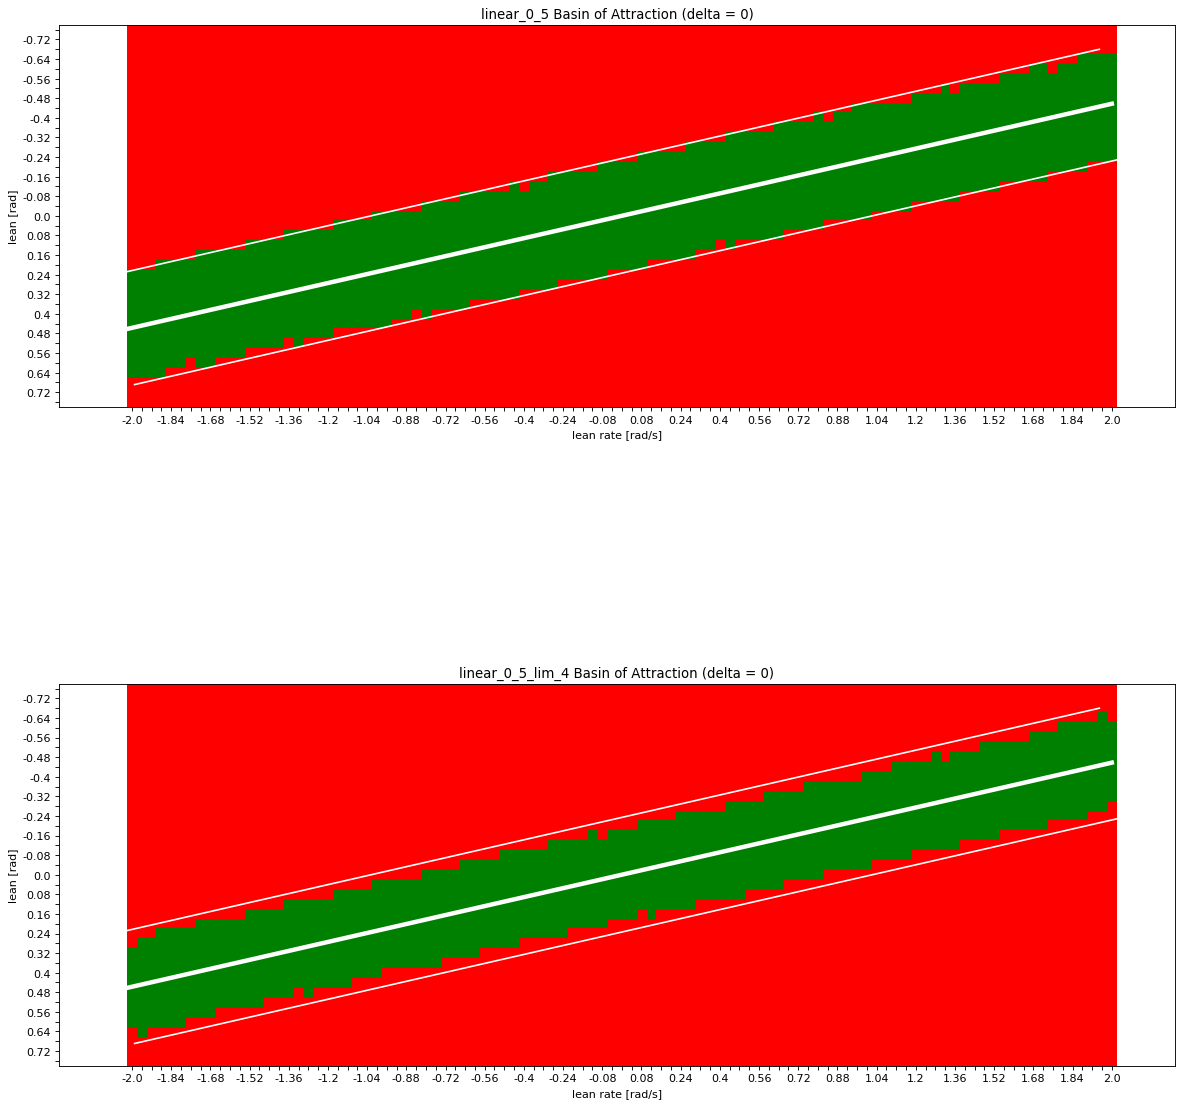

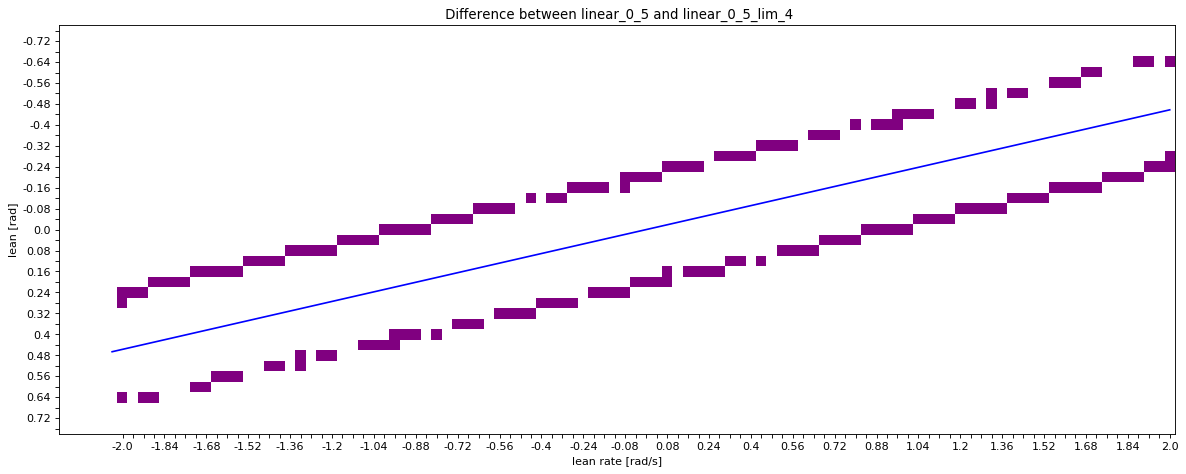

In [240]:
#success_arrays_notloaded = [linear_0_5_SA, linear_0_25_SA]
plot_basin_from_arrays(success_arrays = [linear_0_5_SA, linear_0_5_lim_4] ,
                       names = ["linear_0_5", "linear_0_5_lim_4"], 
                       state_table_flag = state_table_flag,
                      d_vals_list = [d_0_5_lin, d_0_5_lin])